<a href="https://colab.research.google.com/gist/hrishipoola/d96e4d6bc0b525231703541a49262216/garch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moderna: Modeling Volatility with GARCH

## Table of Contents

1. Introduction
2. Install & Import Packages
3. Collect Data
4. Specify & Fit Model
   <br>4a. Constant mean, normal distribution
   <br>4b. Constant mean, skewed t distribution
   <br>4c. AR mean, skewed t distribution
   <br>4d. EGARCH (asymmetric shocks)
   <br>4e. GJR-GARCH (asymmetric shocks)
5. Goodness of Fit (max likelihood, AIC, BIC)
6. Parameter Significance Testing
7. Standardized Residuals
   <br>7a. ACF Plot
   <br>7b. Ljung-Box Test
8. Rolling Window Forecast
   <br>8a. Fixed Window
   <br>8b. Expanding Window
9. Backtesting
10. Dynamic Value at Risk (VaR)
11. References 

## 1. Introduction

Today, we'll model and forecast Moderna (ticker: MRNA) equity volatility using generalized autoregressive conditional heteroskedacity[(GARCH)](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) in order to better manage investment and options risk. I was inspired by a recent [a16z interview](https://a16z.com/2020/12/18/moderna-covid-vaccine-mrna-technology/) with Moderna's CEO Stephane Bancel and a [Datacamp course](https://learn.datacamp.com/courses/garch-models-in-python). 

GARCH provides a more realistic, reliable model for volatility (risk) by incorporating the clustered, time-varying character of volatility. Periods of high or low volatility tend to persist - volatility is more likely to be high at time t if it was also high at time t-1. Rising prices tend to be accompanied with falling volatility (steady uptick) and falling prices tend to be accompanied with rising volatility (panic selling). GARCH(p,q) models variance as a weighted average of past residuals up to lag p and weighted average of variance up to lag q. For example, GARCH(1,1) states that variance of time t equals a constant, omega, plus alpha x residual squared of time t-1, plus beta x variance of time t-1:

$\sigma^2_t = \omega + \alpha * residual^2_{t-1} + \beta * \sigma^2_{t-1}$

$\alpha$ represents how volatility reacts to new information. The larger the $\alpha$, the larger the immediate impact expressed as residuals (prediction errors). For daily observations, $\alpha$ is typically between 0.5 (stable) to around 0.1 (jumpy). The larger the $\beta$, the longer the duration of the impact. $\beta$ is typically between 0.85 and 0.98. Taken together, volatility with high $\alpha$ and low $\beta$ tend to be more spiky. Key requirements are:

$\omega, \alpha, \beta$ are non-negative
<br>$\alpha + \beta < 1$ (mean-reverting)

In the long run, $\sigma = \omega / (1-\alpha - \beta)$

If our GARCH model is working well, it will account for all predictable components and its residuals will be uncorrelated (white noise).

We'll also take into account asymmetric shocks with GJR-GARCH and exponential GARCH (EGARCH), which include a conditional parameter for differing impact of bad and good news on volatility. For example, GJR-GARCH is represented as:

$\sigma^2_t = \omega + \alpha * residual^2_{t-1} + \gamma *I* residual^2_{t-1} +  \beta * \sigma^2_{t-1}$

The additional parameter $\gamma$ takes into account asymmetric shock, where I is an indicator function that equals 1 if the unconditional standard deviation is less than 0. A negative and significant $\gamma$ means bad news increases volatility more than good news of similar magnitude. A positive and significant $\gamma$ means that good news increases volatility more than bad news of the same magnitude. 

We'll specify and fit several models, check goodness of fit, select the optimal model, check parameters and standardized residuals, create a rolling window forecast, backtest, and quantify value at risk (VaR). Try it out on a company you're interested in! In a future post, we'll see how GARCH works with a portfolio. 

Volatility is only one piece of the puzzle. Next steps:
- Model expected returns separately by fitting an ARIMA model
- Run Monte Carlo simulations
- From those draws, generate a realistic high confidence band for future expected MRNA's returns


## 2. Install & Import Packages

In [1]:
!pip install yfinance
!pip install pandas-datareader

# Import yfinance to make Yahoo Finance API call 
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from datetime import datetime
from functools import reduce 

# Import data reader to directly convert Yahoo Finance data into dataframe
from pandas_datareader import data as pdr

!pip install arch
from arch import arch_model

# ACF plot of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf

# Ljunb-Box test of standardized residuals
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set seaborn plot style
sns.set_style("darkgrid")

# Set matplotlib plot style
style.use("fivethirtyeight")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 8.0 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 614.8 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.6 MB/s eta 0:00:0000:0100:01
  Created wheel for peewee: filename=peewee-3.17.6-py3-none-any.whl size=138891 sha256=ba9eb7a1bba7845e048c4c5e0b8298b90dc39c437dbcf4ae8574815be1b6c949
  Stored in directory: /home/shubham/.cache/pip/wheels/a6/5e/0f/8319805c4115320e0d3e8fb5799b114a2e4c4a3d6c7e523b06
Successfully built peewee
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 539.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.3/976.3 kB 2.8 MB/s eta 0:00:0000:0100:01m


## 3. Collect data

This [article](https://www.tandfonline.com/doi/abs/10.1080/13518470500039436) recommends having at least 500 observations when working with a GARCH(1,1) model in order to avoid negative bias and convergence errors. 

In [7]:
pip install yfinance


Note: you may need to restart the kernel to use updated packages.


In [11]:
import yfinance as yf
import pandas as pd

# Fetch Nifty 50 data from Yahoo Finance
mrna = yf.download('^NSEI', start='2018-12-03', end='2023-01-13')

# Check first 3 and last 3 rows
pd.concat([mrna.head(3), mrna.tail(3)])


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-03,10930.700195,10941.200195,10845.349609,10883.750000,10883.750000,409700
2018-12-04,10877.099609,10890.950195,10833.349609,10869.500000,10869.500000,322100
2018-12-05,10820.450195,10821.049805,10747.950195,10782.900391,10782.900391,312300
2023-01-10,18121.300781,18127.599609,17856.000000,17914.150391,17914.150391,283300
2023-01-11,17924.250000,17976.349609,17824.349609,17895.699219,17895.699219,259900
2023-01-12,17920.849609,17945.800781,17761.650391,17858.199219,17858.199219,227800


In [8]:
import pandas_datareader as pdr
import pandas as pd

# Grab data from Yahoo Finance as dataframe
mrna = pdr.get_data_yahoo('N', start='2018-12-03', end='2023-01-13')

# Check first 3 and last 3 rows
pd.concat([mrna.head(3), mrna.tail(3)])


TypeError: string indices must be integers, not 'str'

In [9]:
# Grab data from Yahoo Finance as dataframe
mrna = pdr.get_data_yahoo('MRNA', start='2018-12-03', end='2023-01-13')

# Check first 3 and last 3 rows
pd.concat([mrna.head(3), mrna.tail(3)])

AttributeError: 'NoneType' object has no attribute 'group'

Text(2020-04-12 00:00:00, 18817.5, 'Vaccine FDA EUA application')

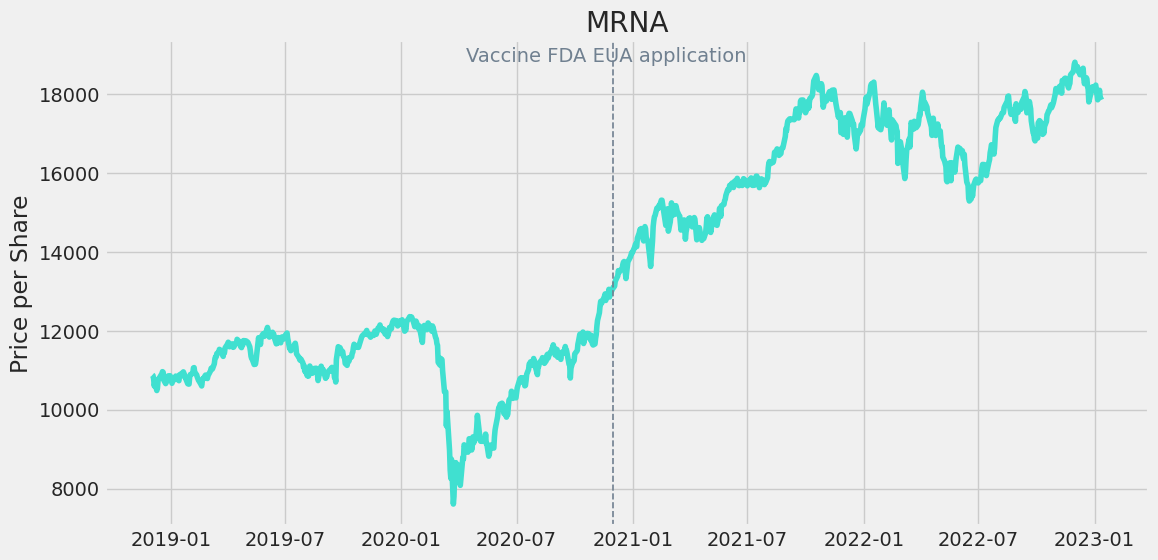

In [12]:
# Keep only Adj Close column
mrna = mrna[['Adj Close']]

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(mrna, color='turquoise')
ax.set(title='NIFTY', ylabel='Price per Share') 

ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-04-12'), max(mrna['Adj Close']+5), 'Vaccine FDA EUA application', color='slategray')

In [71]:
mrna['return'] = mrna.pct_change().dropna() * 100

# Plot
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(mrna['return'].dropna(), color='lightcoral')
ax.set(title='NIFTY', ylabel='% Return') 

ax.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax.text(pd.to_datetime('2020-06-11'), max(mrna['return'].dropna()), 'Vaccine FDA EUA application', color='slategray')

ValueError: Columns must be same length as key

MRNA returns show clear signs of clustering.

In [14]:
# Make sure we drop nans
mrna.dropna(inplace=True)

daily_volatility = mrna['return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_trade_days = 21
monthly_volatility = np.sqrt(monthly_trade_days) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

yearly_trade_days = 252
yearly_volatility = np.sqrt(yearly_trade_days) * daily_volatility
print('Yearly volatility: ', '{:.2f}%'.format(yearly_volatility))

Daily volatility:  1.30%
Monthly volatility:  5.96%
Yearly volatility:  20.63%


/tmp/ipykernel_36135/904621038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrna.dropna(inplace=True)


3 steps to develop GARCH model
- Specify model (assumptions)
- Fit
- Forecast

Model assumptions
- distribution of residuals: normal, t, skewt
- mean model: constant, zero, AR
- volatility model: GARCH, ARCH, EGARCH

Fitting process finds paramaters for which the GARCH model is most likely to generate the observed time series data. 


## 4. Specify & Fit Model

## 4a. Constant mean, normal distribution

In [15]:
basic_gm = arch_model(mrna['return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal') 
gm_result = basic_gm.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1078465613737.3918
Iteration:      2,   Func. Count:     14,   Neg. LLF: 907070777.6537759
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1923.1719388247102
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1781.7782710805072
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1482.7390225086992
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1482.4707244159067
Iteration:      7,   Func. Count:     48,   Neg. LLF: 1482.4705082620978
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1482.4705005959138
Iteration:      9,   Func. Count:     57,   Neg. LLF: 1482.4705005958012
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1482.4705005959138
            Iterations: 9
            Function evaluations: 57
            Gradient evaluations: 9


In [16]:
gm_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1482.47
Distribution:                  Normal   AIC:                           2972.94
Method:            Maximum Likelihood   BIC:                           2992.63
                                        No. Observations:                 1015
Date:                Tue, Jul 30 2024   Df Residuals:                     1014
Time:                        01:27:28   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0925  3.151e-02      2.935  3.335e-03 [3.072e-02,  0.154]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0410  1.637e-02      2.503  1.230e-02 [8.896e-03,7.306e-02]
alpha[1]       0.1196  3.071e-02      3.895  9.825e-05   [5.942e-02,  0.180]
beta[1]        0.8525  3.059e-02     27.868 6.559e-171     [  0.793,  0.912]
============================================================================

Covariance estimator: robust
"""

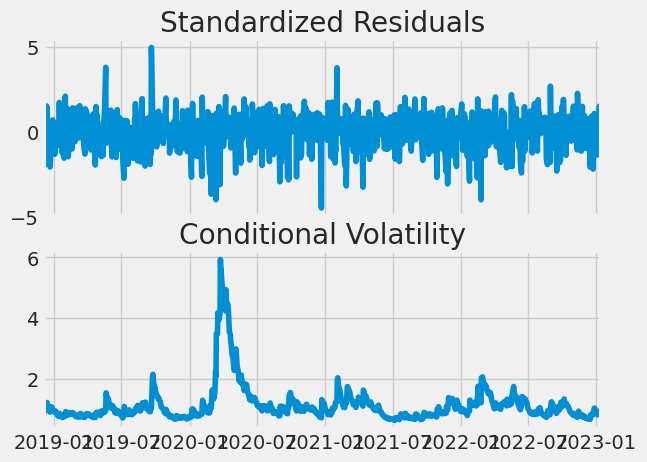

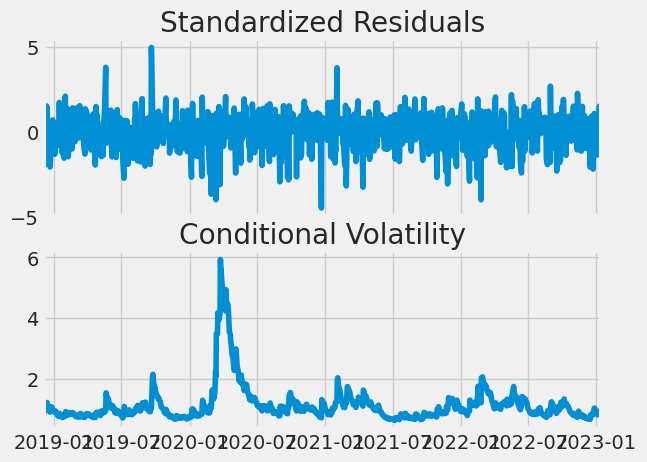

In [17]:
gm_result.plot()

In [18]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2023-01-12  0.753787  0.773753  0.793162  0.812031  0.830373


[Text(0.5, 1.0, 'Distribution of Standardized Residuals')]

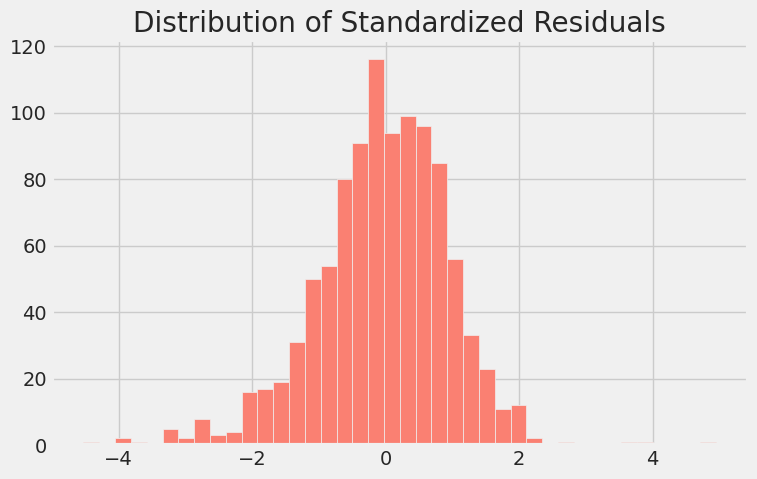

In [19]:
# Calculate standardized residual
gm_std_resid = gm_result.resid / gm_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.hist(gm_std_resid, color='salmon', bins=40)
ax.set(title='Distribution of Standardized Residuals')

The distribution of standardized residuals is closer to a t-distribution with fatter tails than normal and with positive skew. Let's try fitting with a skewt distribution below.




## 4b. Constant mean, skewed t distribution

In [20]:
skewt_gm = arch_model(mrna['return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt') 
skewt_result = skewt_gm.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 67251.74213663452
Iteration:      2,   Func. Count:     18,   Neg. LLF: 139266.38927624928
Iteration:      3,   Func. Count:     27,   Neg. LLF: 14976.309562069966
Iteration:      4,   Func. Count:     36,   Neg. LLF: 15455.566555390673
Iteration:      5,   Func. Count:     44,   Neg. LLF: 39735.70396684882
Iteration:      6,   Func. Count:     52,   Neg. LLF: 1481.3726684816845
Iteration:      7,   Func. Count:     60,   Neg. LLF: 1475.2182371630377
Iteration:      8,   Func. Count:     68,   Neg. LLF: 1459.464837264397
Iteration:      9,   Func. Count:     76,   Neg. LLF: 1450.6531590266443
Iteration:     10,   Func. Count:     84,   Neg. LLF: 1451.5398581132695
Iteration:     11,   Func. Count:     92,   Neg. LLF: 1448.1924613458577
Iteration:     12,   Func. Count:     99,   Neg. LLF: 1448.1867851728543
Iteration:     13,   Func. Count:    106,   Neg. LLF: 1448.1869962075073
Iteration:     14,   Func. Count:    114,   Neg. LLF: 

In [21]:
skewt_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -1448.19
Distribution:      Standardized Skew Student's t   AIC:                           2908.37
Method:                       Maximum Likelihood   BIC:                           2937.91
                                                   No. Observations:                 1015
Date:                           Tue, Jul 30 2024   Df Residuals:                     1014
Time:                                   01:27:47   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0739  2.962e-02      2.495  1.258e-02 [1.586e-02,  0.132]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0416  1.507e-02      2.762  5.754e-03 [1.208e-02,7.113e-02]
alpha[1]       0.1039  2.490e-02      4.172  3.020e-05   [5.509e-02,  0.153]
beta[1]        0.8630  2.899e-02     29.766 1.074e-194     [  0.806,  0.920]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            6.9906      1.408      4.965  6.871e-07    [  4.231,  9.750]
lambda        -0.1947  5.326e-02     -3.656  2.557e-04 [ -0.299,-9.036e-02]
===========================================================================

Covariance estimator: robust
"""

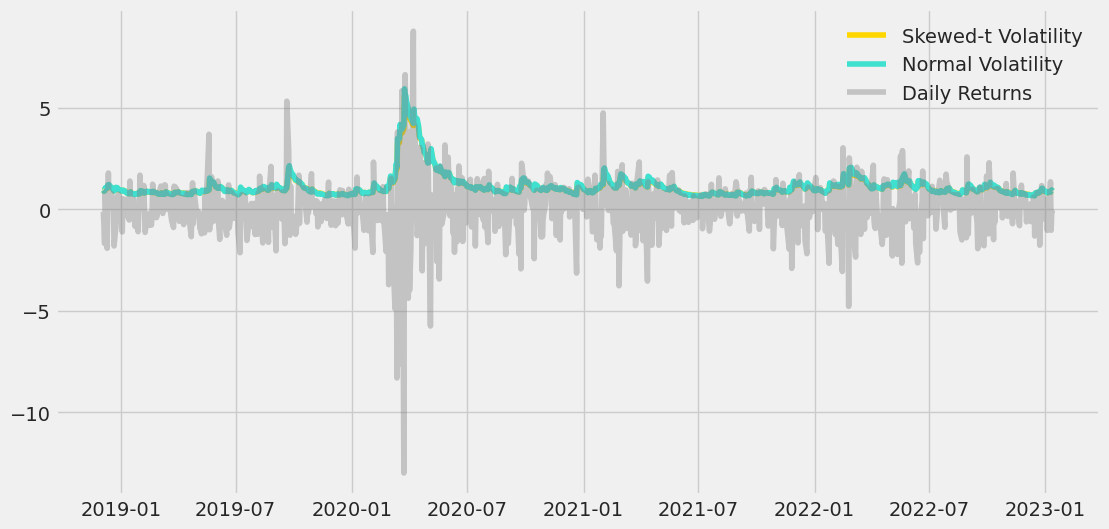

In [22]:
# Get model estimated volatility
normal_volatility = gm_result.conditional_volatility
skewt_volatility = skewt_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(skewt_volatility, color = 'gold', label = 'Skewed-t Volatility')
plt.plot(normal_volatility, color = 'turquoise', label = 'Normal Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

The gold skew-t plot begins to diverge more from the normal plot in March 2020. 

## 4c. Autoregressive (AR) Mean, skewed t distribution

In [23]:
armean_gm = arch_model(mrna['return'], p=1, q=1, mean='AR', lags=1, vol='GARCH', dist='skewt') 
armean_result = armean_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 109543.04139670084
Iteration:      2,   Func. Count:     21,   Neg. LLF: 203427.7642360843
Iteration:      3,   Func. Count:     32,   Neg. LLF: 75913.9675110061
Iteration:      4,   Func. Count:     42,   Neg. LLF: 18251.795321396232
Iteration:      5,   Func. Count:     52,   Neg. LLF: 13305.929056441608
Iteration:      6,   Func. Count:     61,   Neg. LLF: 37646.90699968707
Iteration:      7,   Func. Count:     70,   Neg. LLF: 1476.5449110429297
Iteration:      8,   Func. Count:     79,   Neg. LLF: 1468.8826944857212
Iteration:      9,   Func. Count:     88,   Neg. LLF: 1457.3290056329956
Iteration:     10,   Func. Count:     97,   Neg. LLF: 1449.1203186890293
Iteration:     11,   Func. Count:    106,   Neg. LLF: 1450.5550769556876
Iteration:     12,   Func. Count:    115,   Neg. LLF: 1446.4944976270115
Iteration:     13,   Func. Count:    123,   Neg. LLF: 1446.4914342747827
Iteration:     14,   Func. Count:    131,   Neg. LLF: 1

In [24]:
armean_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                
=========================================================================================
Dep. Variable:                            return   R-squared:                      -0.006
Mean Model:                                   AR   Adj. R-squared:                 -0.007
Vol Model:                                 GARCH   Log-Likelihood:               -1446.49
Distribution:      Standardized Skew Student's t   AIC:                           2906.98
Method:                       Maximum Likelihood   BIC:                           2941.43
                                                   No. Observations:                 1014
Date:                           Tue, Jul 30 2024   Df Residuals:                     1012
Time:                                   01:28:04   Df Model:                            2
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.0720  2.990e-02      2.410  1.597e-02  [1.344e-02,  0.131]
return[1]      0.0375  3.341e-02      1.123      0.262 [-2.797e-02,  0.103]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0426  1.539e-02      2.764  5.704e-03 [1.238e-02,7.273e-02]
alpha[1]       0.1048  2.540e-02      4.125  3.707e-05   [5.500e-02,  0.155]
beta[1]        0.8611  2.969e-02     29.006 5.585e-185     [  0.803,  0.919]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            6.9166      1.378      5.018  5.215e-07    [  4.215,  9.618]
lambda        -0.1851  5.583e-02     -3.315  9.170e-04 [ -0.294,-7.564e-02]
===========================================================================

Covariance estimator: robust
"""

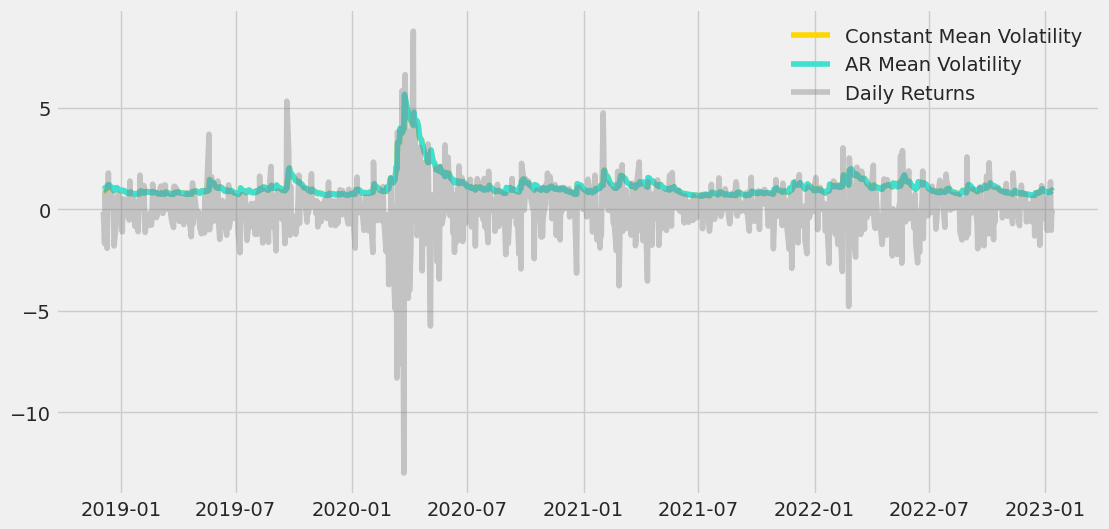

In [25]:
armean_volatility = armean_result.conditional_volatility.dropna() # uses lag, first row will be NaN
skewt_volatility = skewt_volatility.iloc[1:] # drop first row

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(skewt_volatility, color = 'gold', label = 'Constant Mean Volatility')
plt.plot(armean_volatility, color = 'turquoise', label = 'AR Mean Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

In [26]:
# Correlation 
np.corrcoef(skewt_volatility, armean_volatility)[0,1]

0.9998925352023601

Correlation is close to 1 and both models look similar, we can assume the simplest specification for mean - constant mean.  

## 4d. EGARCH (asymmetric shock) 

So far we've assumed that positive and negative movements in return have the same (symmetric) impact on volatility. In reality, they often impact volatility asymmetrically with returns increasing gradually and falling sharply (as companies become more leveraged due to higher debt-to-equity ratio). GJR-GARCH and exponential GARCH (EGARCH) are volatility models for asymmetric shocks that include a conditional parameter (o = 1) for differing impact. 

In [27]:
egarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='EGARCH', dist='skewt') 
egarch_result = egarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 8063.662809967222
Iteration:      2,   Func. Count:     21,   Neg. LLF: 69259.1266167767
Iteration:      3,   Func. Count:     32,   Neg. LLF: 8035.011110808425
Iteration:      4,   Func. Count:     44,   Neg. LLF: 8298.876899625018
Iteration:      5,   Func. Count:     55,   Neg. LLF: 268991.76021247485
Iteration:      6,   Func. Count:     66,   Neg. LLF: 13863.830089652256
Iteration:      7,   Func. Count:     75,   Neg. LLF: 1430.5367572752307
Iteration:      8,   Func. Count:     84,   Neg. LLF: 1430.3545680121833
Iteration:      9,   Func. Count:     93,   Neg. LLF: 1428.3001621281992
Iteration:     10,   Func. Count:    101,   Neg. LLF: 1428.2767968008461
Iteration:     11,   Func. Count:    109,   Neg. LLF: 1428.273324139498
Iteration:     12,   Func. Count:    117,   Neg. LLF: 1428.2710737463153
Iteration:     13,   Func. Count:    125,   Neg. LLF: 1428.2709302167875
Iteration:     14,   Func. Count:    133,   Neg. LLF: 142

In [28]:
egarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - EGARCH Model Results                          
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -1428.27
Distribution:      Standardized Skew Student's t   AIC:                           2870.54
Method:                       Maximum Likelihood   BIC:                           2905.00
                                                   No. Observations:                 1015
Date:                           Tue, Jul 30 2024   Df Residuals:                     1014
Time:                                   01:29:13   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0502  2.957e-02      1.697  8.978e-02 [-7.791e-03,  0.108]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.7973e-03  7.736e-03      0.749      0.454 [-9.364e-03,2.096e-02]
alpha[1]       0.1509  2.400e-02      6.288  3.221e-10      [  0.104,  0.198]
gamma[1]      -0.1305  2.043e-02     -6.390  1.661e-10   [ -0.171,-9.049e-02]
beta[1]        0.9692  7.979e-03    121.465      0.000      [  0.954,  0.985]
                                Distribution                               
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
eta            8.7193      2.147      4.061  4.882e-05    [  4.511, 12.927]
lambda        -0.2053  5.432e-02     -3.779  1.572e-04 [ -0.312,-9.884e-02]
===========================================================================

Covariance estimator: robust
"""

## 4e. GJR-GARCH

In [29]:
gjrgarch_gm = arch_model(mrna['return'], p=1, q=1, o=1, mean='constant', vol='GARCH', dist='skewt') 
gjrgarch_result = gjrgarch_gm.fit()

Iteration:      1,   Func. Count:      9,   Neg. LLF: 70735.2142120833
Iteration:      2,   Func. Count:     20,   Neg. LLF: 59676.01111336486
Iteration:      3,   Func. Count:     30,   Neg. LLF: 31529.57416569473
Iteration:      4,   Func. Count:     40,   Neg. LLF: 19316.459392250385
Iteration:      5,   Func. Count:     49,   Neg. LLF: 1528.8103545650972
Iteration:      6,   Func. Count:     58,   Neg. LLF: 1442.1124545386742
Iteration:      7,   Func. Count:     67,   Neg. LLF: 1442.5256371779315
Iteration:      8,   Func. Count:     76,   Neg. LLF: 45462.244515102924
Iteration:      9,   Func. Count:     85,   Neg. LLF: 1429.6141046462167
Iteration:     10,   Func. Count:     94,   Neg. LLF: 1428.7144673117077
Iteration:     11,   Func. Count:    102,   Neg. LLF: 1428.7083353047221
Iteration:     12,   Func. Count:    110,   Neg. LLF: 1428.7060956483958
Iteration:     13,   Func. Count:    118,   Neg. LLF: 1428.7051952252239
Iteration:     14,   Func. Count:    126,   Neg. LLF: 1

In [30]:
gjrgarch_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Constant Mean - GJR-GARCH Model Results                         
=========================================================================================
Dep. Variable:                            return   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1428.71
Distribution:      Standardized Skew Student's t   AIC:                           2871.41
Method:                       Maximum Likelihood   BIC:                           2905.87
                                                   No. Observations:                 1015
Date:                           Tue, Jul 30 2024   Df Residuals:                     1014
Time:                                   01:29:20   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0532  2.880e-02      1.847  6.468e-02 [-3.240e-03,  0.110]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0361  9.975e-03      3.622  2.920e-04  [1.658e-02,5.568e-02]
alpha[1]   3.4422e-12  1.945e-02  1.769e-10      1.000 [-3.813e-02,3.813e-02]
gamma[1]       0.1647  3.396e-02      4.850  1.237e-06    [9.814e-02,  0.231]
beta[1]        0.8853  2.524e-02     35.074 1.686e-269      [  0.836,  0.935]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            8.6651      2.133      4.062  4.862e-05 [  4.484, 12.846]
lambda        -0.2061  5.389e-02     -3.824  1.312e-04 [ -0.312, -0.100]
========================================================================

Covariance estimator: robust
"""

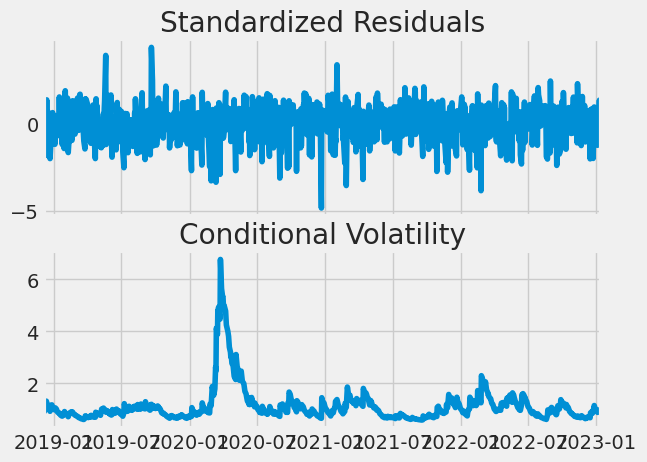

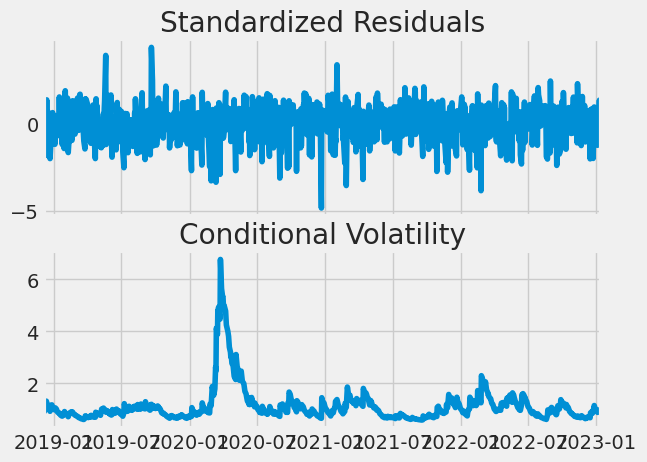

In [31]:
gjrgarch_result.plot()

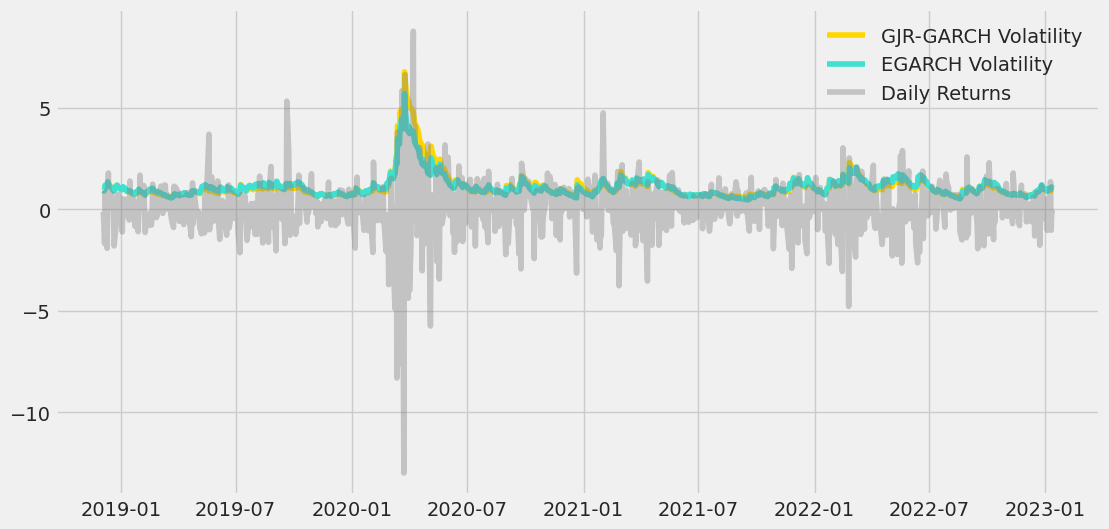

In [32]:
# Get model estimated volatility
gjrgarch_volatility = gjrgarch_result.conditional_volatility
egarch_volatility = egarch_result.conditional_volatility

# Plot model fitting results
plt.figure(figsize=(12,6))
plt.plot(gjrgarch_volatility, color = 'gold', label = 'GJR-GARCH Volatility')
plt.plot(egarch_volatility, color = 'turquoise', label = 'EGARCH Volatility')
plt.plot(mrna['return'], color = 'grey', label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right', frameon=False)

## 5. Goodness of Fit

1. Log Likelhood (maximize)
2. Information Criteria (AIC, BIC) (minimize)

Based on log likelihood, AIC, BIC below, GJR-GARCH is our best fitting model

In [33]:
# Function to create dataframe of log likelihood, AIC, BIC for each model
def goodness_of_fit():
  global df
  model_names = ['normal', 'skewt', 'GJR-GARCH', 'EGARCH']
  models = [gm_result, skewt_result, gjrgarch_result, egarch_result]
  likelihood = [model.loglikelihood for model in models]
  aic = [model.aic for model in models]
  bic = [model.bic for model in models]
  dict = {'model':model_names, 'log likelihood':likelihood, 'aic':aic,'bic':bic}
  df = pd.DataFrame(dict).set_index('model')
  return df

goodness_of_fit()

,log likelihood,aic,bic
model,,,
normal,-1482.470501,2972.941001,2992.631577
skewt,-1448.186587,2908.373173,2937.909037
GJR-GARCH,-1428.705041,2871.410081,2905.868589
EGARCH,-1428.270926,2870.541852,2905.000360


In [69]:
# Highlight max log likelihood
df.style.highlight_max(subset='log likelihood', color = 'black', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1482.470501,2972.941001,2992.631577
skewt,-1448.186587,2908.373173,2937.909037
GJR-GARCH,-1428.705041,2871.410081,2905.868589
EGARCH,-1428.270926,2870.541852,2905.000360


GJR-GARCH performs the best in terms of log likelihood.

In [68]:
# Highlight min AIC, BIC
df.style.highlight_min(subset=['aic', 'bic'], color = 'black', axis = 0) 

,log likelihood,aic,bic
model,,,
normal,-1482.470501,2972.941001,2992.631577
skewt,-1448.186587,2908.373173,2937.909037
GJR-GARCH,-1428.705041,2871.410081,2905.868589
EGARCH,-1428.270926,2870.541852,2905.000360


GJR-GARCH has the lowest AIC, while GJR-GARCH and skewed t have the lowest BIC. Based on this, let's select GJR-GARCH as our model.  

## 6. Parameter Significance Testing

Significance testing of parameters is one piece of understanding our model, but, in terms of variable selection, it should be taken with a grain of salt ([article](https://robjhyndman.com/hyndsight/tests2/)) - it's possible to have an insignificant coefficient for a variable that's useful for forecasting as well as having a significant variable that's better omitted for forecasting. We'll also look at residuals as well as AIC and BIC below. 




In [36]:
# Get parameter stats from model summary
parameters = pd.DataFrame({'parameter': gjrgarch_result.params,
                           'p-value': gjrgarch_result.pvalues})

parameters

,parameter,p-value
mu,5.321435e-02,6.467630e-02
omega,3.613319e-02,2.920220e-04
alpha[1],3.442221e-12,1.000000e+00
gamma[1],1.646958e-01,1.236589e-06
beta[1],8.853129e-01,1.685812e-269
eta,8.665119e+00,4.861515e-05
lambda,-2.060950e-01,1.312338e-04


The high $\alpha$ indicates a large immediate impact on residuals, while the relatively high $\beta$ indicates a persisting impact. The negative $\gamma$ implies that bad news increases volatility more than good news of similar magnitude. From the significance test, omega and alpha aren't significant (p-values above 0.05). However, we should be [careful about removing them](https://stats.stackexchange.com/questions/202493/should-i-keep-a-non-significant-intercept-in-a-garch-model) based on this. 




## 7. Standardized Residuals

[Text(0.5, 1.0, 'Standardized Resduals')]

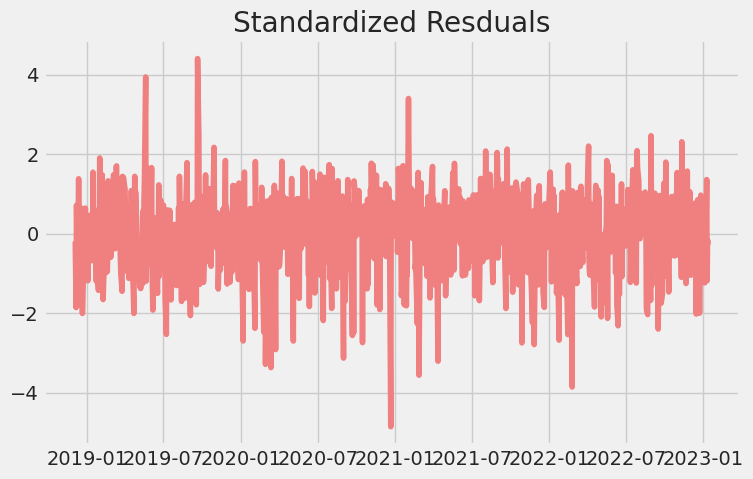

In [37]:
# Calculate standardized residual
gjrgarch_std_resid = gjrgarch_result.resid / gjrgarch_result.conditional_volatility

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(gjrgarch_std_resid, color='lightcoral')
ax.set(title='Standardized Resduals') 

Autocorrelation tests randomness in standardized residuals for each lag and any significant autocorrelation in standardized residuals means the model may not be sound.

## 7a. ACF Plot

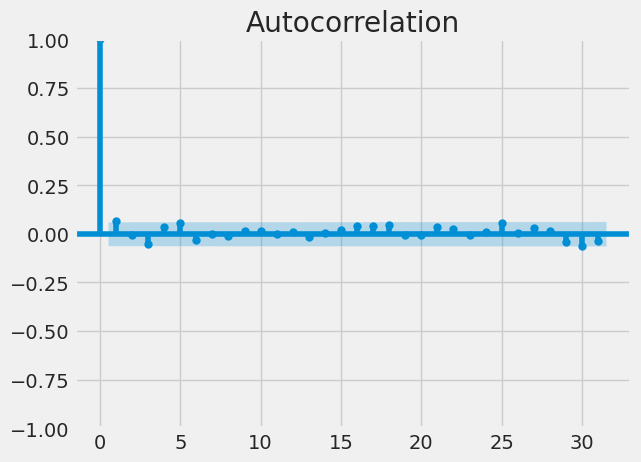

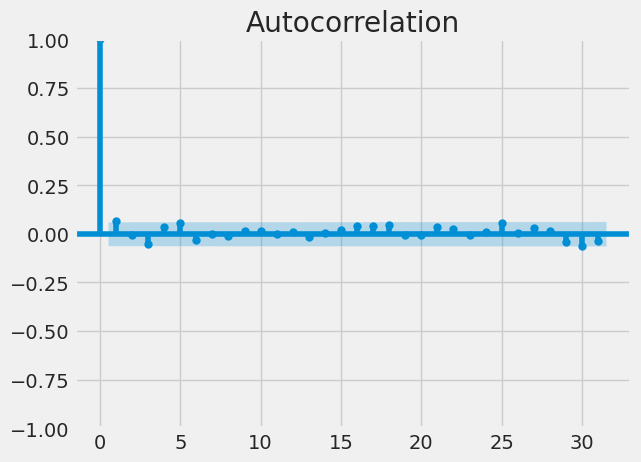

In [38]:
plot_acf(gjrgarch_std_resid, alpha=0.05)

The ACF plots illustrate that there aren't any significant autocorrelations between residuals so the residuals represent white noise.

## 7b. Ljung-Box Test

Ljung-Box tests for overall randomness of standardized residuals. The null hypothesis is that the data is independently distributed. P-values <5% means the residuals aren't independently distributed and the model isn't sound. 


In [40]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test
lb_test = acorr_ljungbox(gjrgarch_std_resid, lags=10)


All the p-values are above 5% meaning the null hypothesis can't be rejected and the standardized residuals are independently distributed. 

## 8. Rolling Window Forecast

To avoid lookback bias and be more responsive to recent events, let's create rolling window forecasts with both fixed and expanding windows. When setting the window size, too large a window may include obsolete data while too small a window might exclude relevant information (and increase variance). As we have a bit over 500 trading days in our data set and we've seen dramatic recent macro shifts and events related to vaccine development, we'll set the start location going back half a year, the window size to 60 trading days, and the forecast period to 30 days.   

## 8a. Fixed Window

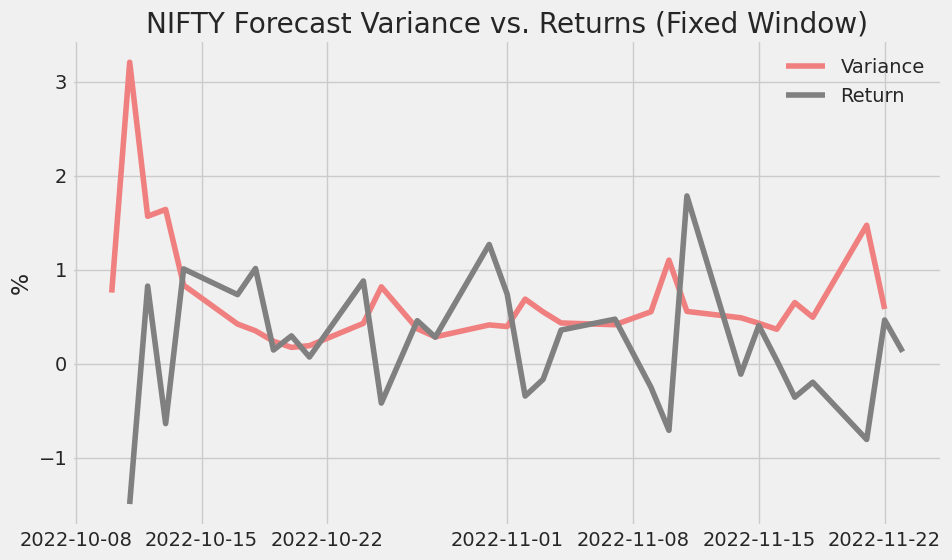

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the number of trading days in a year (usually around 252)
yearly_trade_days = 252

# Start location set to going back with half a year of trading days
start_loc = len(mrna) - round(0.5 * yearly_trade_days)

# Window of 60 days
end_loc = start_loc + 60

forecasts = {}

for i in range(30):
    # Ensure indices are within bounds
    if i + start_loc >= len(mrna) or i + end_loc >= len(mrna):
        print(f"Index out of bounds: i={i}, start_loc={start_loc}, end_loc={end_loc}")
        break

    # Fit with fixed rolling window
    gjrgarch_fixed_rolling_result = gjrgarch_gm.fit(first_obs=i + start_loc, 
                                                  last_obs=i + end_loc, 
                                                  update_freq=5,
                                                  disp='off')
    
    # 1-period variance forecast and save the result
    temp_result = gjrgarch_fixed_rolling_result.forecast(horizon=1).variance
    
    # Check if temp_result has data and is indexed correctly
    if not temp_result.empty:
        try:
            fcast = temp_result.iloc[0]  # Get the forecast variance for the next period
            forecasts[fcast.name] = fcast
        except IndexError:
            print(f"Index error when accessing temp_result for i={i}")
    else:
        print(f"Empty forecast result for i={i}")

# Create DataFrame, transpose to get dates as rows and variance as columns     
forecast_var_fixed = pd.DataFrame(forecasts).T

# Ensure forecast_var_fixed is not empty
if not forecast_var_fixed.empty:
    # Plot the forecast variance
    plt.figure(figsize=(10,6))
    plt.plot(forecast_var_fixed, color='lightcoral', label='Variance')
    
    # Ensure the range used for returns is within bounds
    if (start_loc + 60 <= len(mrna)) and (end_loc + 30 <= len(mrna)):
        plt.plot(mrna.iloc[start_loc + 60:end_loc + 30]['return'], color='gray', label='Return')
    else:
        print("The range for returns exceeds the length of the data.")
    
    plt.ylabel('%')
    plt.legend(frameon=False)
    plt.title('NIFTY Forecast Variance vs. Returns (Fixed Window)')
    plt.show()
else:
    print("No forecast data available to plot.")


Model does a fairly good job as variance seems to fluctuate with returns. 

## 8b. Expanding Window

In [54]:
# Start location set to going back with a half year of trading days
start_loc = len(mrna) - round(0.5 * yearly_trade_days)

# Window of 60 days
end_loc = start_loc + 60

forecasts={}

for i in range(30):

    # Fit with fixed rolling window
    gjrgarch_expanding_rolling_result = gjrgarch_gm.fit(first_obs = start_loc, 
                                              last_obs = i + end_loc, 
                                              update_freq = 5,
                                              disp='off')
    
    # 1-period variance forecast and save the result
    temp_result_expanding = gjrgarch_expanding_rolling_result.forecast(horizon = 1).variance
    fcast = temp_result_expanding.iloc[i + end_loc]
    forecasts[fcast.name] = fcast

# Create dataframe, transpose to get dates as rows and variance as column     
forecast_var_expanding = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10,6))
plt.plot(forecast_var_expanding, color = 'lightcoral', label='Forecast Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color = 'gray', label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns (Expanding Window)')

IndexError: single positional indexer is out-of-bounds

The expanding window doesn't seem to do as good a job in the beginning of the forecast period as with the fixed window.

Text(0.5, 1.0, 'MRNA Forecast Variance vs. Returns')

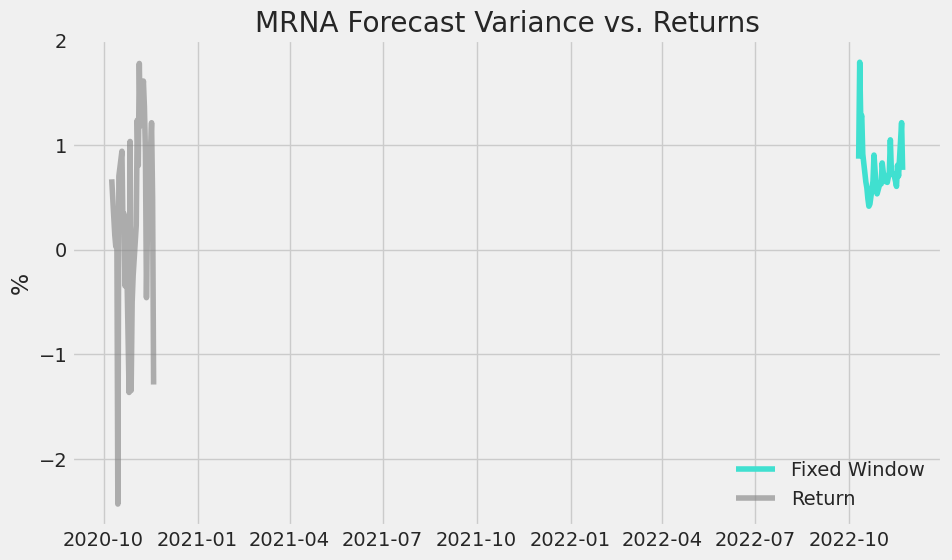

In [55]:
# Calculate volatility for fixed and expanding windows
fixed_window_volatility = np.sqrt(forecast_var_fixed)
expanding_window_volatility = np.sqrt(forecast_var_expanding)

# Plot volatility for fixed and expanding windows
plt.figure(figsize=(10,6))
plt.plot(expanding_window_volatility, color = 'lightcoral', label='Expanding Window')
plt.plot(fixed_window_volatility, color = 'turquoise', label='Fixed Window')
plt.plot(mrna['return']['2020-10-09':'2020-11-19'], color = 'gray', alpha=0.6, label='Return')
plt.ylabel('%')
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns')

The fixed window forecast shows more volatility (more conservative) than the expanding window forecast.  

## 9. Backtesting

In [56]:
# Variance from model
actual_var = gjrgarch_result.conditional_volatility ** 2 
actual_var = actual_var['2020-10-09':'2020-11-19']

# Convert actual and forecast variance to numpy arrays
actual_var, forecast_var_fixed = np.array(actual_var), np.array(forecast_var_fixed)
import pandas as pd
import matplotlib.pyplot as plt

# Define the number of trading days in a year
yearly_trade_days = 252  # Adjust if necessary

# Determine start and end locations
start_loc = len(mrna) - round(0.5 * yearly_trade_days)
end_loc = start_loc + 60

forecasts = {}

for i in range(30):
    # Fit the model with fixed rolling window
    gjrgarch_expanding_rolling_result = gjrgarch_gm.fit(first_obs=start_loc, 
                                                      last_obs=i + end_loc, 
                                                      update_freq=5,
                                                      disp='off')
    
    # 1-period variance forecast and save the result
    temp_result_expanding = gjrgarch_expanding_rolling_result.forecast(horizon=1).variance
    fcast = temp_result_expanding.iloc[i + end_loc]
    forecasts[fcast.name] = fcast

# Create dataframe, transpose to get dates as rows and variance as columns     
forecast_var_expanding = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10, 6))
plt.plot(forecast_var_expanding, color='lightcoral', label='Forecast Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color='gray', label='Return')
plt.ylabel('%')
plt.xlabel('Date')  # Add label for x-axis
plt.legend(frameon=False)
plt.title('MRNA Forecast Variance vs. Returns (Expanding Window)')
plt.show()

def evaluate(observation, forecast): 

    # MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
   
    # MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))

    # MAPE: not in scikitlearn, let's calculate it ourselves
    mape = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(mape))
    
    return mae, mse, mape

# Backtest model with MAE, MSE
evaluate(actual_var, forecast_var_fixed)

ValueError: Found input variables with inconsistent numbers of samples: [29, 30]

MAPE of 39.4% is still quite high. In the future, we could try to improve model performance by adjusting forecast rolling window, model selection, and model parameters. 

## 10. Dynamic Value at Risk (VaR)

Since value at risk (VaR) is forward-looking, we'll generate a forecast and grab the forward-looking mean and volatility. There are 2 ways to calculate dynamic VaR: 

1. Parametric VaR: assumed distribution of standardized residuals
2. Empirical VaR: observed distribution of standardized residuals

In [57]:
# Check our GJR-GARCH params - we'll use degrees of freedom (nu) and skew (lambda) for our VaR
gjrgarch_result.params

mu          5.321435e-02
omega       3.613319e-02
alpha[1]    3.442221e-12
gamma[1]    1.646958e-01
beta[1]     8.853129e-01
eta         8.665119e+00
lambda     -2.060950e-01
Name: params, dtype: float64

Iteration 0: temp_result_expanding shape: (67, 1)
Iteration 0: Attempting to access index: 949
Index 949 is out-of-bounds for temp_result_expanding.
Iteration 1: temp_result_expanding shape: (66, 1)
Iteration 1: Attempting to access index: 950
Index 950 is out-of-bounds for temp_result_expanding.
Iteration 2: temp_result_expanding shape: (65, 1)
Iteration 2: Attempting to access index: 951
Index 951 is out-of-bounds for temp_result_expanding.
Iteration 3: temp_result_expanding shape: (64, 1)
Iteration 3: Attempting to access index: 952
Index 952 is out-of-bounds for temp_result_expanding.
Iteration 4: temp_result_expanding shape: (63, 1)
Iteration 4: Attempting to access index: 953
Index 953 is out-of-bounds for temp_result_expanding.
Iteration 5: temp_result_expanding shape: (62, 1)
Iteration 5: Attempting to access index: 954
Index 954 is out-of-bounds for temp_result_expanding.
Iteration 6: temp_result_expanding shape: (61, 1)
Iteration 6: Attempting to access index: 955
Index 955 i

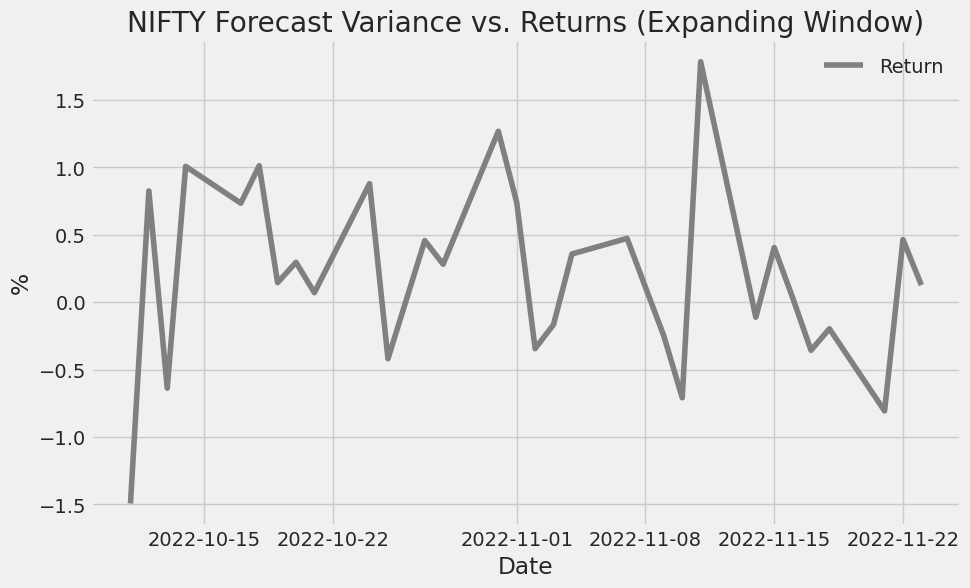

/tmp/ipykernel_36135/4123087684.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nu = gjrgarch_result.params[5]  # t distribution degrees of freedom
/tmp/ipykernel_36135/4123087684.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lam = gjrgarch_result.params[6]  # t distribution skew


Degrees of freedom (nu): 8.665118992686917
Skew (lambda): -0.20609502627479803
5% parametric quantile:  -1.7329437684817706
5% empirical quantile:  -1.7385072512030586


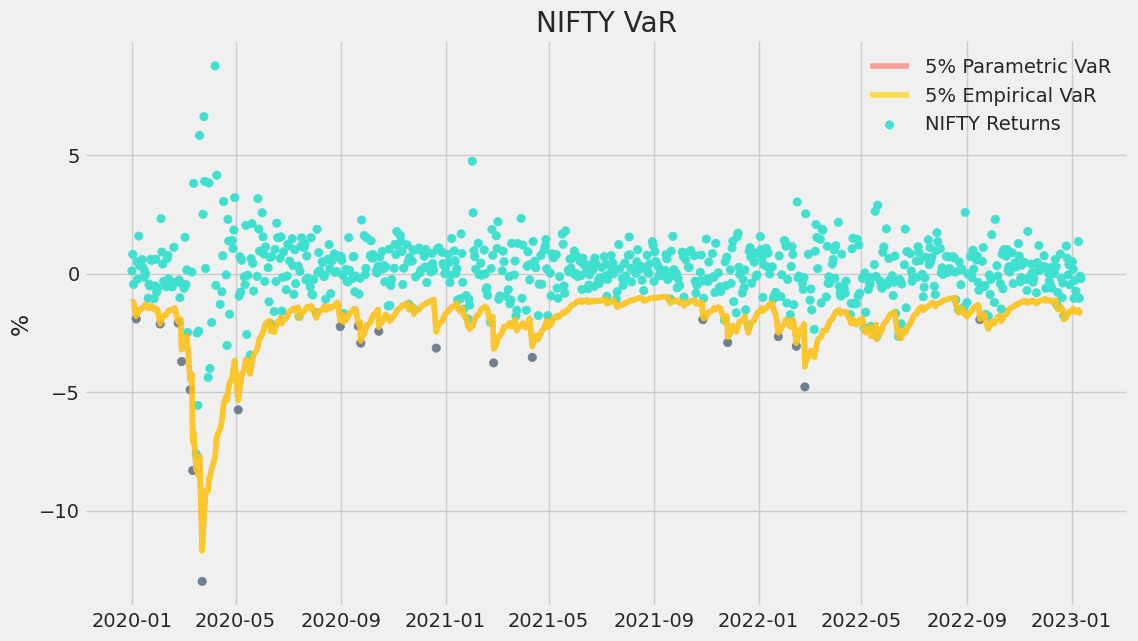

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model

# Define the number of trading days in a year
yearly_trade_days = 252  # Adjust if necessary

# Determine start and end locations
start_loc = len(mrna) - round(0.5 * yearly_trade_days)
end_loc = start_loc + 60

forecasts = {}

for i in range(30):
    try:
        # Fit the model with fixed rolling window
        gjrgarch_expanding_rolling_result = gjrgarch_gm.fit(first_obs=start_loc, 
                                                          last_obs=i + end_loc, 
                                                          update_freq=5,
                                                          disp='off')
        
        # 1-period variance forecast and save the result
        temp_result_expanding = gjrgarch_expanding_rolling_result.forecast(horizon=1).variance

        # Debug print to check the length and index range
        print(f"Iteration {i}: temp_result_expanding shape: {temp_result_expanding.shape}")
        print(f"Iteration {i}: Attempting to access index: {i + end_loc}")

        if i + end_loc < len(temp_result_expanding):
            fcast = temp_result_expanding.iloc[i + end_loc]
            forecasts[fcast.name] = fcast
        else:
            print(f"Index {i + end_loc} is out-of-bounds for temp_result_expanding.")
    except Exception as e:
        print(f"Error during forecasting iteration {i}: {e}")

# Create DataFrame, transpose to get dates as rows and variance as columns     
forecast_var_expanding = pd.DataFrame(forecasts).T

# Plot the forecast variance
plt.figure(figsize=(10, 6))
plt.plot(forecast_var_expanding, color='lightcoral', label='Forecast Variance')
plt.plot(mrna.iloc[start_loc+60:end_loc+30]['return'], color='gray', label='Return')
plt.ylabel('%')
plt.xlabel('Date')  # Add label for x-axis
plt.legend(frameon=False)
plt.title('NIFTY Forecast Variance vs. Returns (Expanding Window)')
plt.show()

# GJRGARCH model results
try:
    nu = gjrgarch_result.params[5]  # t distribution degrees of freedom
    lam = gjrgarch_result.params[6]  # t distribution skew
    print(f"Degrees of freedom (nu): {nu}")
    print(f"Skew (lambda): {lam}")
except IndexError as e:
    print(f"IndexError: {e}. Check the indices of gjrgarch_result.params.")

# Forecast from 2020-01-01 onward 
try:
    gjrgarch_forecast = gjrgarch_result.forecast(start='2020-01-01')
    mean_forecast = gjrgarch_forecast.mean['2020-01-01':]
    variance_forecast = gjrgarch_forecast.variance['2020-01-01':]
except KeyError as e:
    print(f"KeyError: {e}. Check the forecast date ranges and available data.")

# Parametric quantile
try:
    q_parametric = gjrgarch_gm.distribution.ppf(0.05, [nu, lam])
    print('5% parametric quantile: ', q_parametric)
except Exception as e:
    print(f"Error calculating parametric quantile: {e}")

# Parametric VaR
try:
    VaR_parametric = mean_forecast.values + np.sqrt(variance_forecast).values * q_parametric
    VaR_parametric = pd.DataFrame(VaR_parametric, columns=['5%'], index=variance_forecast.index)
except Exception as e:
    print(f"Error calculating parametric VaR: {e}")

# Empirical quantile
try:
    q_empirical = gjrgarch_std_resid.quantile(0.05)NIFTY
    print('5% empirical quantile: ', q_empirical)
except AttributeError as e:
    print(f"AttributeError: {e}. Check if gjrgarch_std_resid is correctly defined and contains residuals.")

# Empirical VaR
try:
    VaR_empirical = mean_forecast.values + np.sqrt(variance_forecast).values * q_empirical
    VaR_empirical = pd.DataFrame(VaR_empirical, columns=['5%'], index=variance_forecast.index)
except Exception as e:
    print(f"Error calculating empirical VaR: {e}")

# Plot VaR
plt.figure(figsize=(12, 7))
plt.plot(VaR_parametric, color='salmon', label='5% Parametric VaR', alpha=0.7)
plt.plot(VaR_empirical, color='gold', label='5% Empirical VaR', alpha=0.7)

try:
    colors = np.where(mrna['return']['2020-01-01':] < VaR_empirical['5%'], 'slategray', 'turquoise')  # where return < VaR, point is dark gray
    plt.scatter(variance_forecast.index, mrna['return']['2020-01-01':], color=colors, label='NIFTY Returns')
except KeyError as e:
    print(f"KeyError: {e}. Check if 'return' column and date range exist in mrna.")

plt.legend(loc='upper right', frameon=False)
plt.ylabel('%')
plt.title('NIFTY VaR')
plt.show()



The parametric and empircal VaR are similar. The GJR-GARCH model looks like it's doing a pretty good job as fewer than 5% of the returns (in red) fall below the VaR threshold (VaR exceedence), which is our risk limit. More than 5% points falling below the threshold would mean our model is underestimating risk. The lower the VaR threshold line, the larger the model's loss estimates (more conservative).

Interestingly, as we'd expect with Moderna, VaR is lowest at the start of the the 1st major lockdown in the U.S. and when the company applied for FDA EUA for its covid vaccine, as well as key moments in vaccine development. 


Text(2020-08-17 00:00:00, 18812.5, 'Vaccine FDA EUA application')

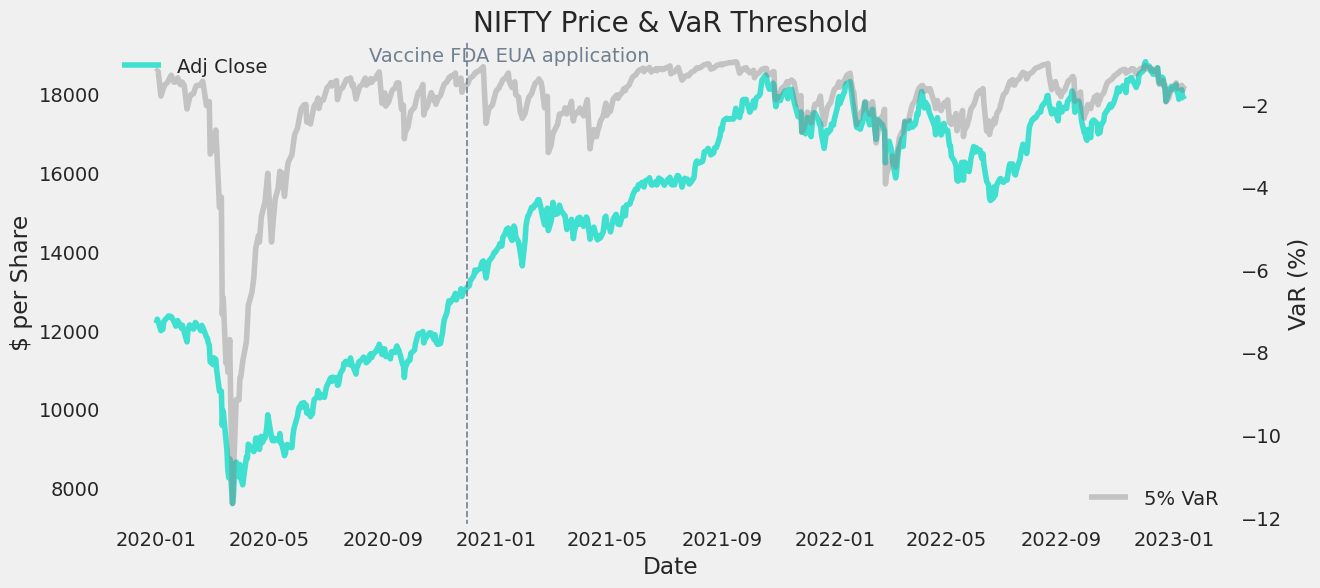

In [63]:
fig, ax1 = plt.subplots(figsize=(13, 6))
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)

VaR_parametric = -VaR_parametric 
ax1.plot(mrna.loc[VaR_parametric.index[0]:].index, mrna.loc[VaR_parametric.index[0]:]['Adj Close'], color='turquoise', label='Adj Close')
ax2.plot(VaR_parametric['5%'].index, VaR_parametric['5%'], color='grey', label='5% VaR', alpha=0.4)

ax1.set(title='NIFTY Price & VaR Threshold', xlabel='Date',ylabel='$ per Share')
ax2.set(ylabel='VaR (%)')
ax1.legend(loc='upper left', frameon=False)
ax2.legend(frameon=False)

ax1.axvline(pd.to_datetime('2020-11-30'), color='slategray', lw=1.2, linestyle='--')
ax1.text(pd.to_datetime('2020-08-17'), max(mrna['Adj Close']), 'Vaccine FDA EUA application', color='slategray')

Similarly to the above chart, the VaR threshold peaks at the start of the 1st major lockdown in the U.S. and at vaccine FDA EUA application. In the past year, the VaR threshold increased, as expected, during key events and with increasing return. 

## 11. References

https://learn.datacamp.com/courses/garch-models-in-python

https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/

https://pyflux.readthedocs.io/en/latest/garch.html

https://www.tandfonline.com/doi/abs/10.1080/13518470500039436

https://stats.stackexchange.com/questions/175400/optimal-lag-order-selection-for-a-garch-model

https://stats.stackexchange.com/questions/136267/maximum-likelihood-in-the-gjr-garch1-1-model?noredirect=1&lq=1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

https://www.amazon.de/Market-Risk-Analysis-Financial-Instruments/dp/B009NNW5A8

https://stats.stackexchange.com/questions/246113/what-to-do-with-an-insignificant-intercept-in-a-garch-model

https://stats.stackexchange.com/questions/202493/should-i-keep-a-non-significant-intercept-in-a-garch-model

https://vlab.stern.nyu.edu/docs/volatility/GJR-GARCH

